In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from yt.frontends.boxlib.data_structures import AMReXDataset
yt.set_log_level(50)

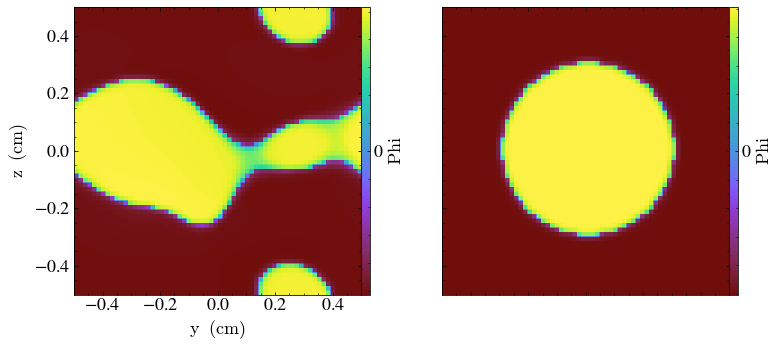

In [2]:
ts = yt.load('binary_mixture/plt?????')
ds = ts[-1]
p1 = yt.SlicePlot(ds, 0, ('boxlib','phi'))

ts = yt.load('binary_droplet/plt?????')
ds = ts[-1]
p2 = yt.SlicePlot(ds, 0, ('boxlib','phi'))

from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure()

# See http://matplotlib.org/mpl_toolkits/axes_grid/api/axes_grid_api.html
# These choices of keyword arguments produce a four panel plot that includes
# four narrow colorbars, one for each plot.  Axes labels are only drawn on the
# bottom left hand plot to avoid repeating information and make the plot less
# cluttered.
grid = AxesGrid(
    fig,
    (0.075, 0.075, 0.85, 0.85),
    nrows_ncols=(1, 2),
    axes_pad=1.0,
    label_mode="1",
    share_all=True,
    cbar_location="right",
    cbar_mode="each",
    cbar_size="3%",
    cbar_pad="0%",
)

for i, p in enumerate([p1,p2]):
    pl = p.plots[('boxlib','phi')]
    pl.figure = fig
    pl.axes = grid[i].axes
    pl.cax = grid.cbar_axes[i]
    p._setup_plots()

#plt.savefig("binary.png")
plt.show()


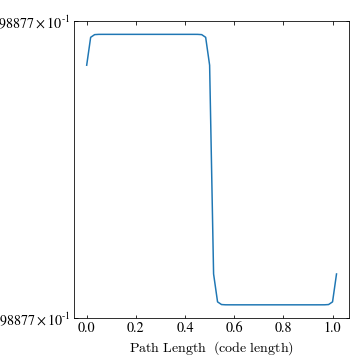

In [3]:
ts = yt.load('flat_interface/T_0.51/plt??????')
ds = ts[-1]
p = yt.LinePlot(ds, 'phi', (0,0,0), (1,0,0), 64)
#p.save('profile.png')
p

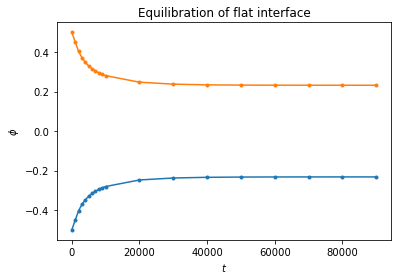

In [4]:
ts = yt.load('flat_interface/T_0.54/plt?????')
times = []
dn = []
for ds in ts[:]:
    ad = ds.all_data()
    times.append(ds.current_time)
    dn.append(ad.quantities.extrema('phi'))
dn = np.array(dn)
plt.xlabel("$t$")
plt.ylabel("$\phi$")
plt.title("Equilibration of flat interface")
plt.plot(times,dn,'.-')
plt.show()

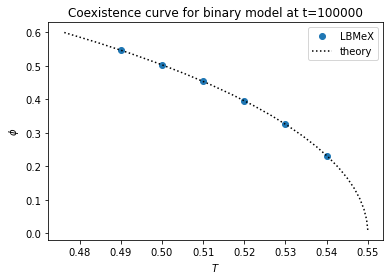

In [5]:
L = 64
t = 100000
rho = 1.0
Lambda = 1.1
nn = np.linspace(0.01,0.6,20)
Tt = Lambda*nn/rho/np.log((rho+nn)/(rho-nn))
Ts = [ 0.49, 0.50, 0.51, 0.52, 0.53, 0.54 ]
ns = []
for T in Ts:
    ds = yt.load('flat_interface/T_{:.2f}/plt{:05d}'.format(T,t))
    ad = ds.all_data()
    ns.append(ad.quantities.extrema('phi'))
ns = np.array(ns)
plt.plot(Ts,ns[:,1],'o',label='LBMeX')
plt.plot(Tt,nn,'k:',label='theory')
plt.ylabel('$\phi$')
plt.xlabel('$T$')
plt.title('Coexistence curve for binary model at t=%d'%t)
plt.legend()
#plt.savefig('coexistence.png')
plt.show()


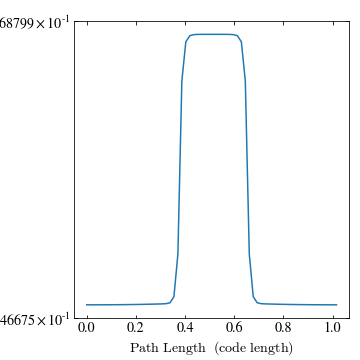

In [6]:
ts = yt.load('binary_droplet/kappa_0.02/R_0.15/plt?????')
ds = ts[-1]
p = yt.LinePlot(ds, 'phi', (0.5,0.5,0), (0.5,0.5,1), 64)
#p.save('profile.png')
p

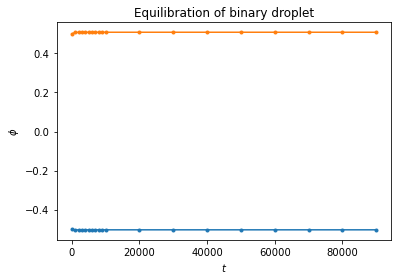

In [7]:
ts = yt.load('binary_droplet/kappa_0.01/R_0.30/plt?????')
times = []
dn = []
for ds in ts[:]:
    ad = ds.all_data()
    times.append(ds.current_time)
    dn.append(ad.quantities.extrema('phi'))
dn = np.array(dn)
plt.xlabel("$t$")
plt.ylabel("$\phi$")
plt.title("Equilibration of binary droplet")
plt.plot(times,dn,'.-')
plt.show()

Surface tension from linear fit: kappa = 0.01, sigma = 0.2513011146578599
Surface tension from linear fit: kappa = 0.02, sigma = 0.41925913699508044


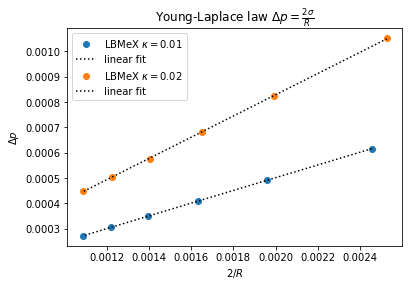

In [8]:
for kappa in [ 0.01, 0.02 ]:
    rs = []
    ps = []
    for R in [ 0.20, 0.25, 0.30, 0.35, 0.40, 0.45 ]:
        ts = yt.load('binary_droplet/kappa_{:.2f}/R_{:.2f}/plt*'.format(kappa,R))
        ds = ts[-1]
        ad = ds.all_data()
        center = ds.r[0.5,0.5,0.5]
        corner = ds.r[0.0,0.0,0.0]
        rho_d = 0.5*(center['rho']+center['phi'])[0].value
        rho_s = 0.5*(corner['rho']+corner['phi'])[0].value
        pin = center['p_bulk']
        pout = corner['p_bulk']
        M = (0.5*(ad['rho']+ad['phi'])-rho_s).sum().value
        r = np.cbrt(3/4/np.pi*M/(rho_d-rho_s))
        P = pin-pout
        rs.append(r)
        ps.append(P)
    rs = np.array(rs)*64
    ps = np.array(ps)
    sigma, b = np.polyfit(2/rs,ps,1)
    print(r"Surface tension from linear fit: kappa = %.2f, sigma ="%kappa,*sigma)
    plt.plot(2/rs,ps,'o',label=r'LBMeX $\kappa=%.2f$'%kappa)
    plt.plot(2/rs,sigma*2/rs+b,'k:',label='linear fit')
plt.title(r"Young-Laplace law $\Delta p = \frac{2\sigma}{R}$")
plt.xlabel('$2/R$')
plt.ylabel('$\Delta p$')
plt.legend()
plt.show()

In [9]:
import scipy.optimize, scipy.integrate

def coexistence(T, Lambda):
    phi0 = scipy.optimize.fsolve(lambda phi: -Lambda/2*phi/rho + T/2*np.log((rho+phi)/(rho-phi)), x0=0.5)
    return phi0

def profile(kappa, T=0.5, Lambda=1.1):

    def fun(x, y):
        phi, psi = y
        dphi = psi
        dpsi = - Lambda/(2*kappa)*phi/rho + T/(2*kappa)*np.log((rho+phi)/(rho-phi))
        return np.vstack([dphi, dpsi])

    def bc(ya, yb):
        return np.array([ya[0]+phi0,yb[0]-phi0]).reshape(2,)

    x = np.linspace(-L//2+1, L//2, L)
    phi0 = coexistence(T, Lambda)
    y0 = np.vstack([phi0*np.tanh(x), phi0*(1-np.tanh(x)**2)])

    res = scipy.integrate.solve_bvp(fun, bc, x, y0)
    
    return x,res.sol(x)[0]

def free_energy(phi, kappa, T=0.5, Lambda=1.1):
    C1 = (rho+phi)/2
    C2 = (rho-phi)/2
    f = Lambda/4*rho*(1-phi**2/rho**2) - T*rho + T*C1*np.log(C1) + T*C2*np.log(C2) \
        + kappa/2*np.linalg.norm(np.gradient(rho))**2 + kappa/2*np.linalg.norm(np.gradient(phi))**2
    return f

def surface_tension(kappa, T=0.5, Lambda=1.1):
    C1 = profile(kappa)
    sigma = free_energy(C1[1], kappa, T, Lambda).sum()/L
    return sigma

-0.5731344607389796
-0.5627282192150457


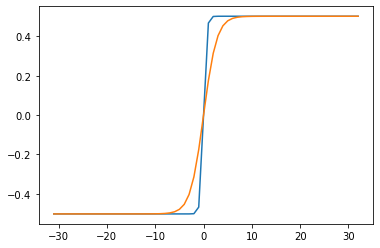

In [10]:
for kappa in [ 0.01, 0.2 ]:
    x, C1 = profile(kappa)
    sigma = surface_tension(kappa)
    print(sigma)
    plt.plot(x, C1);
plt.show()

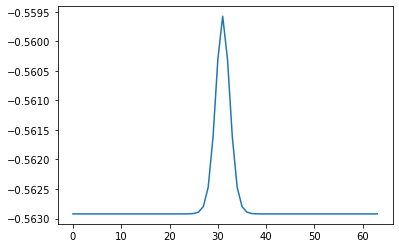

In [11]:
_, C1 = profile(kappa)
f = free_energy(C1, kappa)
plt.plot(f)
plt.show()